# Making the Controllable Emoprox Experiment!

## Introduction

In this paradigm, the most important component of the motion of the circles is how close they are, i.e. their proximity. It is a relatively valid indicator for the subject to judge how soon a shock will arrive. Similarly, the direction and speed of the circles will have be given importance by the participant when judging the timing of a shock. So, to begin we will generate patterns of proximity that have some desireable characteristics. Let's enumerate them here at the beginning:

### Proximity Qualities
 1. A somewhat standard duration of time (>5s) during which the circles are consistently moving toward or away from each other
 2. Equal amounts of time points during which the circles are approaching or retreating
 3. Distribution of proximity values throughout the experiment that is skewed toward the circles being near more often
 4. A prescribed number of shocks occur during the block
 5. Randomized tangential movement to mask the somewhat deterministic nature of the circle movements

### A simple solution to a difficult problem

When considering how to tackle the first two items, I tried to build a model that would satisfy these conditions. However, after a while of tinkering with it, I noticed that the specification in a random framework produced chaotic behavior that messed everything up after a few hundred timepoints. So I settled on a simple solution that actually satisfies these two conditions sufficiently.

1. A somewhat standard duration of time (>5s) during which the circles are consistently moving toward or away from each other
2. Equal amounts of time points during which the circles are approaching or retreating

For the sake of the dynamic connectivity analysis that Mahshid came up with, it was desireable to have long periods of approach and retreat. In fact, periods that were too short were a complete waste of data. So it seemed obvious to me that picking a smooth periodic function would satisfy this condition perfectly. I chose cosine at first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

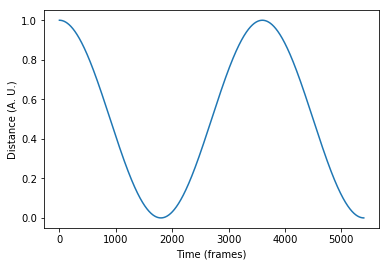

In [2]:
x = np.arange(5400)
plt.plot(0.5*(np.cos(3*np.pi*x/5400) + 1))
plt.xlabel("Time (frames)")
plt.ylabel("Distance (A. U.)")

However, if you can imagine, after a few tests of this movement, it became apparent that the circles would slow down as they reached the extreme values of the function. This looked weird and unnatural, especially when the circles touched at distance = 0. So I decided to put some sharpness in the function to give the circles a property that looked a lot like the elastic exchange of momentum.

In [3]:
from scipy.signal import sawtooth


def sharper_cos(x):
    """
    Mixes cosine and sawtooth function to sharpen the extremes of the cosine function.
    """
    
    # the two signals i'm going to mix
    smooth = np.cos(x)

    # generates the sharp signal and aligns the peaks to the smooth signal
    sharp = -sawtooth(x, 0.5) + np.sign(smooth) * sawtooth(np.arccos(0.5), 0.5)
    sharp /= 2 * (1 + sawtooth(np.arccos(0.5), 0.5))  # scale the sharp signal
    sharp += np.sign(smooth) / 2  # shift the sharp signal peaks to overlap the smooth

    # replace the peaks of the smooth with the peaks of the sharp
    out = smooth.copy()
    out[np.abs(out) > 0.5] = sharp[np.abs(out) > 0.5]

    return out

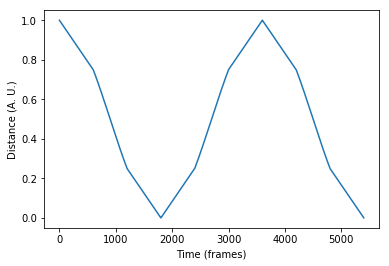

In [4]:
x = np.arange(5400)
plt.plot(0.5 * (sharper_cos(3 * np.pi * x / 5400) + 1))
plt.xlabel("Time (frames)")
plt.ylabel("Distance (A. U.)")

Okay, great! Now we can use these in a piecewise fashion to construct a timecourse of varying proximity and velocity. Here's an example.

Let's have:
* a section of retreat that lasts for 200 frames
* a section of approach that lasts for 300 frames

We'll recall that section of constant sign in a cosine function is $\pi$ radians in length, and that

$$cos(x + \pi) = -cos(x)$$

(Note that I'm still referring to our sharper cosine function as $cos$ as it shares many of the same properties as cosine)

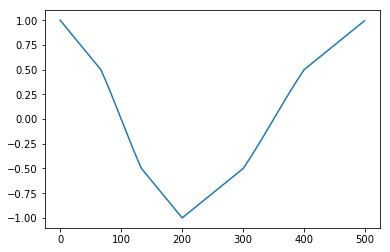

In [5]:
tc = np.append(
    sharper_cos(np.arange(200) / 200 * np.pi),
    -sharper_cos(np.arange(300) / 300 * np.pi))

plt.plot(tc)

Looks good! Now, what if we wanted to have the sections traverse different values for proximity?

Let's pick a starting value, a midpoint value, and an ending point. We'll use 0.7, 0.1, and 0.9, respectively. Now, note that the piece spans 1 to -1 and has a midpoint at 0, so to scale the first piece from 0.7 to 0.1, we can use this formula:

$$\Delta p = p_f - p_0$$

$$piece = p_0 + \frac{\Delta p}{2} * \left( 1 - cos\frac{x}{T} \right)$$

where $p_0$ and $p_f$ are the starting and ending proximities for the piece, and T is the length of the piece. Note, we have now reparameterized to take the difference in the start and end points. This will be important later.

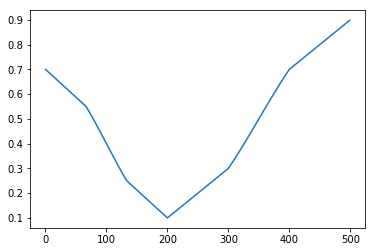

In [6]:
def piece(length, start=0, diff=1):
    """
    Generate a piece of our time course that is either approaching or retreating,
    given the starting distance and desired difference in distance at the end point.
    """
    x = np.arange(length)
    return start + diff / 2 * (1 - sharper_cos(x / length * np.pi))


tc = np.append(piece(200, 0.7, -0.6), piece(300, 0.1, 0.8))

plt.plot(tc)